In [51]:
from keras.models import load_model
from mtcnn.mtcnn import MTCNN
from PIL import Image
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from os import listdir
from os.path import isdir
import cv2
import matplotlib.pyplot as plt
from numpy import expand_dims

from random import choice
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

import pickle

In [2]:
directory = 'image/train/'

In [30]:
for subdir in ['ben_afflek', 'elton_john']:
    path = directory + subdir + '/'
    for filename in listdir(path):
        image = cv2.imread(path + filename)
#         image.convert('RGB')
        
        detector = MTCNN()
        results = detector.detect_faces(image)
        for i in range(0, len(results)):
            x1, y1, width, height = results[i]['box']
            
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize((160, 160))
        
        break
    break

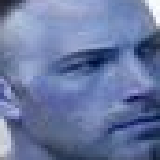

In [31]:
image

In [3]:
def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    
    return face_array

def load_faces(directory):
    faces = list()
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
        
    return faces

def load_dataset(directory):
    X, y = list(), list()
#     for subdir in listdir(directory):
    for subdir in ['ben_afflek', 'elton_john']:
        path = directory + subdir + '/'
        if not isdir(path):
            continue
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces))]
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        X.extend(faces)
        y.extend(labels)
        
    return asarray(X), asarray(y)

In [4]:
directory = 'image/train/'

In [5]:
X_train, y_train = load_dataset(directory)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john


In [86]:
len(X_train)

31

In [6]:
X_test, y_test = load_dataset('image/val/')

>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john


In [15]:
savez_compressed('image.npz', X_train, y_train, X_test, y_test)

In [7]:
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [70]:
data = load('image.npz')
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [ ]:
model = load_model('model/facenet_keras.h5')

In [9]:
X_train_prep = list()
for face_pixels in X_train:
    embedding = get_embedding(model, face_pixels)
    X_train_prep.append(embedding)
X_train_prep = asarray(X_train_prep)

In [10]:
X_test_prep = list()
for face_pixels in X_test:
    embedding = get_embedding(model, face_pixels)
    X_test_prep.append(embedding)
X_test_prep = asarray(X_test_prep)

In [11]:
savez_compressed('image_prep.npz', X_train_prep, y_train, X_test_prep, y_test)

In [13]:
in_encoder = Normalizer(norm='l2')
X_train_prep = in_encoder.transform(X_train_prep)
X_test_prep = in_encoder.transform(X_test_prep)

In [71]:
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

In [73]:
encoder_filename = 'model/target_encoder.pkl'
pickle.dump(out_encoder, open(encoder_filename, 'wb'))

In [74]:
encoder_filename = 'model/target_encoder.pkl'
out_encoder = pickle.load(open(encoder_filename, 'rb'))

In [55]:
out_encoder

LabelEncoder()

In [75]:
out_encoder.inverse_transform(y_test[0])

/home/aryoerlangga/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'ben_afflek'

In [45]:
model = SVC(kernel='linear', probability=True)
model.fit(X_train_prep, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
yhat_train = model.predict(X_train_prep)
yhat_test = model.predict(X_test_prep)

In [17]:
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)

In [18]:
score_train, score_test

(1.0, 1.0)

In [68]:
selection = choice([i for i in range(X_test.shape[0])])
random_face_pixels = X_test[selection]
random_face_emb = X_test_prep[selection]
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

/home/aryoerlangga/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [43]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

In [47]:
out_encoder

LabelEncoder()

In [67]:
out_encoder.inverse_transform(yhat_class)

/home/aryoerlangga/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0])

/home/aryoerlangga/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted: ben_afflek (86.105)
Expected: ben_afflek


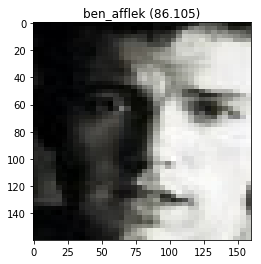

In [44]:
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()